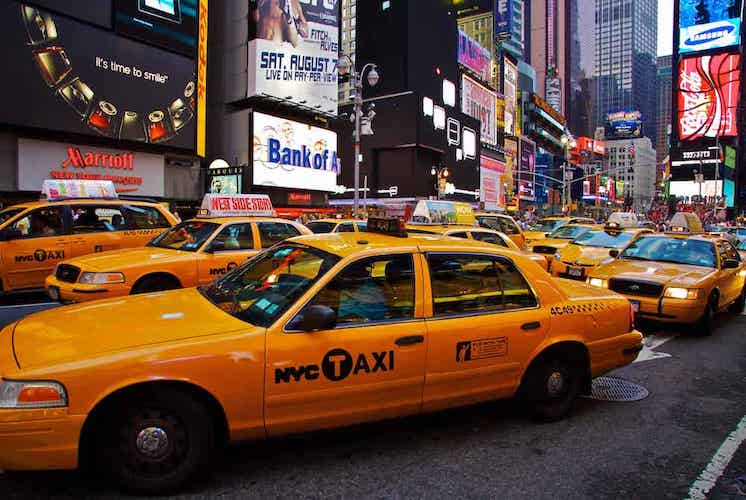

# How much will your taxi trip cost in New York City?
---

Author: Apoorv Mittal 

The data which we have loaded will help me predict the fare amount which is my dependent variable. We will be trying to predict this by the pickup location (latitude and longitude), dropoff location, number of passengers, time of the day and the week of the day. We will also try and adding some features which we extract from our data itself. In the end we will analyse which features were considered the best. 


## Table of Contents

1. [Getting Started](#Getting-Started)
    - [1.1 Importing Libraries](#1.1-Importing-Libraries)
    - [1.2 Dataset Source](#1.2-Dataset-Source)
    - [1.3 Reading the data](#1.3-Reading-the-data)
    - [1.4 Describing the data](#1.4-Describing-the-data)
    
2. [Cleaning the data](#Cleaning-the-data)
    - [2.1 Fare](#2.1-Cleaning-Fare)
    - [2.2 Passenger Count](#2.2-Cleaning-Passenger-Count)
    - [2.3 Pickup and Dropoff Coordinates](#2.3-Cleaning-Coordinates)
3. [Visualizing data](#Visualizing-data) 
    - [3.1 Pickup Locations](#3.1-Pickup-Locations)
    - [3.2 Dropoff Locations](#3.2-Dropoff-Locations)
    - [3.3 Fares Locations](#3.3-Fares-Locations)

4. [Adding features](#Adding-features)
    - [4.1 Distances](#4.1-Distances)
        - [Haversine distance](#Haversine-distance)
        - [Taxicab Distance](#Taxicab-Distance)
        - [Euclidean distance](#Euclidean-distance)
        - [Vertical or horizontal distance](#Vertical-or-horizontal-distance)
    - [4.2 Fare Per Kilometer](#4.2-Fare-Per-Kilometer)
    - [4.3 Time](#4.3-Time)
5. [Machine Learning](#Machine-Learning)  
    - [5.1 Splitting Data](#5.1-Splitting-Data)
    - [5.2 Finding Correlations](#5.2-Finding-Correlations)
    - [5.3 Hypothesis Testing](#5.3-Hypothesis-Testing)
    - [5.4 F Tests](#5.3-F-Tests)
    - [5.5 Making Predictions](#5.5-Making-Predictions)
        - [Linear Model](#Linear-Model)
        - [Random Forest](#Random-Forest)
        - [K-NN model](#K-NN-model)
        - [Decision Trees](#Decision-Trees)
        - [Linear SVR](#Linear-SVR)
6. [Conclusion](#Conclusion)


# Getting Started
## 1.1 Importing Libraries

Before we see what the data is all about let's get our notebook ready. We will need all the libraries which we have used thoroughout the semester. 

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18


import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# datetime to tell day of the week
import datetime

# See residual relationship in modals
from numpy.polynomial.polynomial import polyfit

## 1.2 Dataset Source


The data for this project was collected from [kaggle](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) from their cometitions tab. 

## 1.3 Reading the data

We have a huge dataset of 55 million values while I have a puny computer and therefore it takes a really big toll reading all the data in a dataframe. As a result we will reading around a million values and then we can always add more data to make our predictions better. 

We also tell pandas to automatically parse the data in the data file and all drop the `key` column which contains a unique identifier for every trip but it would not help us to predict anything with the trip. Lastly we remove any row with a missing entry because we cannot fill them our selves. We will touch on this topic later. 

In [2]:
data = pd.read_csv('NYC Taxi Fare Data/train.csv', nrows = 1_000_000, 
                   parse_dates = ['pickup_datetime']).drop(columns = 'key')

# Remove na
data = data.dropna()
data.head()

fare_amount     pickup_datetime  pickup_longitude  pickup_latitude  \
0        4.500 2009-06-15 17:26:21           -73.844           40.721   
1       16.900 2010-01-05 16:52:16           -74.016           40.711   
2        5.700 2011-08-18 00:35:00           -73.983           40.761   
3        7.700 2012-04-21 04:30:42           -73.987           40.733   
4        5.300 2010-03-09 07:51:00           -73.968           40.768   

   dropoff_longitude  dropoff_latitude  passenger_count  
0            -73.842            40.712                1  
1            -73.979            40.782                1  
2            -73.991            40.751                2  
3            -73.992            40.758                1  
4            -73.957            40.784                1

## 1.4 Describing the data

Our Dataframe has the following columns\:

* pickup_datetime - timestamp value indicating when the taxi ride started.
* pickup_longitude - float for longitude coordinate of where the taxi ride started.
* pickup_latitude - float for latitude coordinate of where the taxi ride started.
* dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
* dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
* passenger_count - integer indicating the number of passengers in the taxi ride.



Let's see what is the summary of statistics of our data. 

As you can we have 23 less than 3 million values. Those 23 are the ones we removed as they had missing entries. Moreover this table also shows us that our data has a lot of outlier. For example, the minimum value of `fare_amount` is negative which is absolutely rubbish. Also minimum and maximum values of `latitude` and `longitute` of pickup and dropoff locations are literally out of the Earth. Even there have been rides with 0 `passenger_count` and some with 208 people. Clearly we will need to do a lot of cleaning even before we are able to use this data. 

# Cleaning the data

As we saw above we need to clean a lot our data. First, lets look at the how our dependent variable `fare_amount` is distrubuted. 

Text(0.5, 1.0, 'Distribution of Fare')

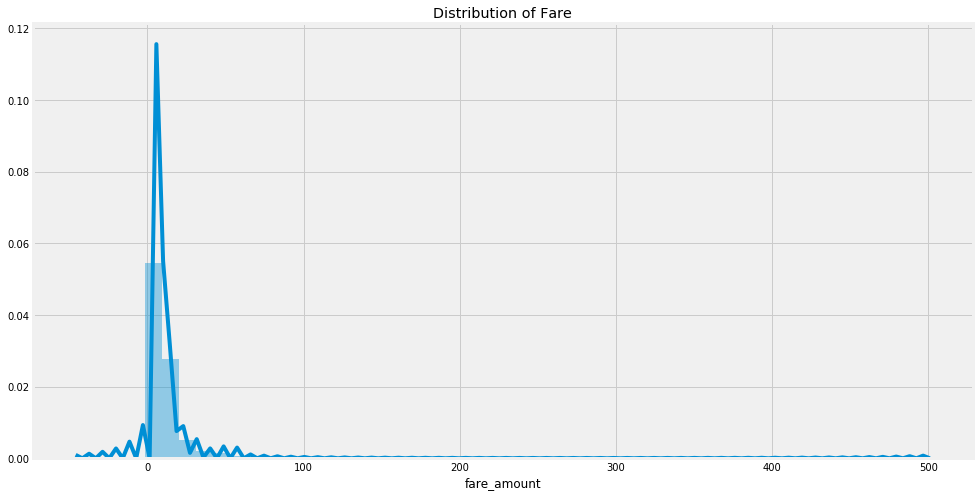

In [3]:
plt.figure(figsize= (15,8))
sns.distplot(data.fare_amount)
plt.title('Distribution of Fare')

## 2.1 Cleaning Fare

First lets remove all Outliers from `fare_amount`. According to [investopedia.com](https://www.investopedia.com/articles/personal-finance/021015/uber-versus-yellow-cabs-new-york-city.asp) the minimum fare of a taxi is \$2.5. I will also remove any `fare_amount` more than \$150 because I believe that fare more than that has to be of someone going outside NYC and therefore useless to our model. 

In [4]:
data = data[data.fare_amount >= 2.5][data.fare_amount <= 150]

Now lets create bins for teh `fare_amount`. This will help us with analysis later. 

Text(0.5, 1.0, 'Fares in bins')

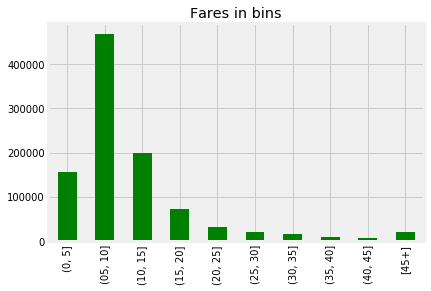

In [5]:
# Bin the fare and convert to string
binss = list(range(0, 50, 5))
data['fare_bin'] = pd.cut(data.fare_amount, bins = binss).astype(str)

# replace so that sorting is correct this took me sooo long to figure out bro
data.loc[data['fare_bin'] == '(5, 10]', 'fare_bin'] = '(05, 10]'

# As you could see in the Distribution of fare above there are not a lot of fares after 45 so lets put then in one bin
data.loc[data['fare_bin'] == 'nan', 'fare_bin'] = '[45+]'

data.fare_bin.value_counts().sort_index().plot.bar(color="g")
plt.title('Fares in bins')

## 2.2 Cleaning Passenger Count

Now lets take a look at outliers in `passenger_count`

Text(0.5, 1.0, 'Trips with # of passengers')

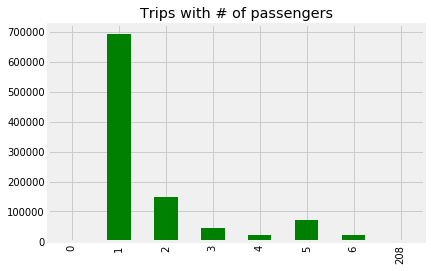

In [6]:
data.passenger_count.value_counts().sort_index().plot.bar(color="g")
plt.title('Trips with # of passengers')

As you can see we should just remove trips with `passenger_count` <=0 or > 6.

In [7]:
data = data[data.passenger_count > 0][data.passenger_count <= 6]

## 2.3 Cleaning Coordinates

Now lets see what we can do about the `latitude` and `longitudes` of the pickup and dropoff locations. 

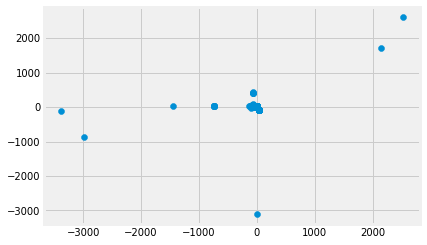

In [8]:
plt.scatter(x = data.pickup_longitude, y = data.pickup_latitude )

As we can see we have no clue what ranges of latitue and longitudes NYC comes in. Therefore lets search online. 

After a lot of time I got to know where does every map gets its map and the site is [openstreetmap.org](https://www.openstreetmap.org/export#map=11/40.7353/-73.8607) and this is where I searched for NYC city limit latitude and longitute. This comes out to be 40.9317 to 40.5425 for latitude and -74.2065 to -73.6029 for longitute. So now lets remove those outliers. 

In [9]:
# pickup 
data = data[data.pickup_longitude >= -74.2065][data.pickup_longitude <= -73.6029]
data = data[data.pickup_latitude >= 40.5425][data.pickup_latitude <= 40.9317]

# dropoff 
data = data[data.dropoff_longitude >= -74.2065][data.dropoff_longitude <= -73.6029]
data = data[data.dropoff_latitude >= 40.5425][data.dropoff_latitude <= 40.9317]

Now lets see our magnaficent clean data:

In [10]:
data.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count   974467.000        974467.000       974467.000         974467.000   
mean        11.298           -73.975           40.751            -73.974   
std          9.414             0.035            0.027              0.034   
min          2.500           -74.205           40.547            -74.205   
25%          6.000           -73.992           40.737            -73.992   
50%          8.500           -73.982           40.753            -73.981   
75%         12.500           -73.968           40.768            -73.965   
max        150.000           -73.604           40.931            -73.603   

       dropoff_latitude  passenger_count  
count        974467.000       974467.000  
mean             40.751            1.691  
std               0.031            1.306  
min              40.543            1.000  
25%              40.736            1.000  
50%              40.754            1.000  
75%              40.768            2.000  
max              40.932            6.000

**Interesting fact** The mean of the `latitudes` and `longitudes` come out to be the same latitude and longitude which google maps gives us when you write New York City. 

Now Finally lets remove any locations with the same coordinates for pickup and dropoff locations

In [11]:
data = data[data['pickup_longitude'] !=  data['dropoff_longitude']][data['pickup_latitude'] != data['dropoff_latitude']]

In [12]:
data.head()

fare_amount     pickup_datetime  pickup_longitude  pickup_latitude  \
0        4.500 2009-06-15 17:26:21           -73.844           40.721   
1       16.900 2010-01-05 16:52:16           -74.016           40.711   
2        5.700 2011-08-18 00:35:00           -73.983           40.761   
3        7.700 2012-04-21 04:30:42           -73.987           40.733   
4        5.300 2010-03-09 07:51:00           -73.968           40.768   

   dropoff_longitude  dropoff_latitude  passenger_count  fare_bin  
0            -73.842            40.712                1    (0, 5]  
1            -73.979            40.782                1  (15, 20]  
2            -73.991            40.751                2  (05, 10]  
3            -73.992            40.758                1  (05, 10]  
4            -73.957            40.784                1  (05, 10]

# Visualizing data

Now lets see the plot of pickup locations and dropoff locations.

In [13]:
coordinate_tuple = (-74.1508, -73.7320, 40.5618, 40.9309)
seed = 100
nyc = plt.imread('map.png')
# this function is used to plot data on the NYC map lat and long is Series of locations to be plotted, 
# coordinates is the max values of the map, myc_map is 
#  the new york map, s is the marker size, alpha is blending value, 
# title is the  title of the plot, color is color of plot
def plot_on_map(lat, long, coordinates = coordinate_tuple, nyc_map =nyc , s=10, alpha=0.2,title = 'NYC Map', color = 'r'):
    fig, axs = plt.subplots(figsize=(12, 16))
    
    axs.scatter(long, lat, zorder=1, alpha=alpha, c=color, s=s)
    axs.set_xlim((coordinates[0], coordinates[1]))
    axs.set_ylim((coordinates[2], coordinates[3]))
    axs.set_title(title)
    axs.imshow(nyc_map, zorder=0, extent=coordinates)

##  3.1 Pickup Locations 

First lets create a random sample of **pickup locations** and plot it on an image of NYC. 

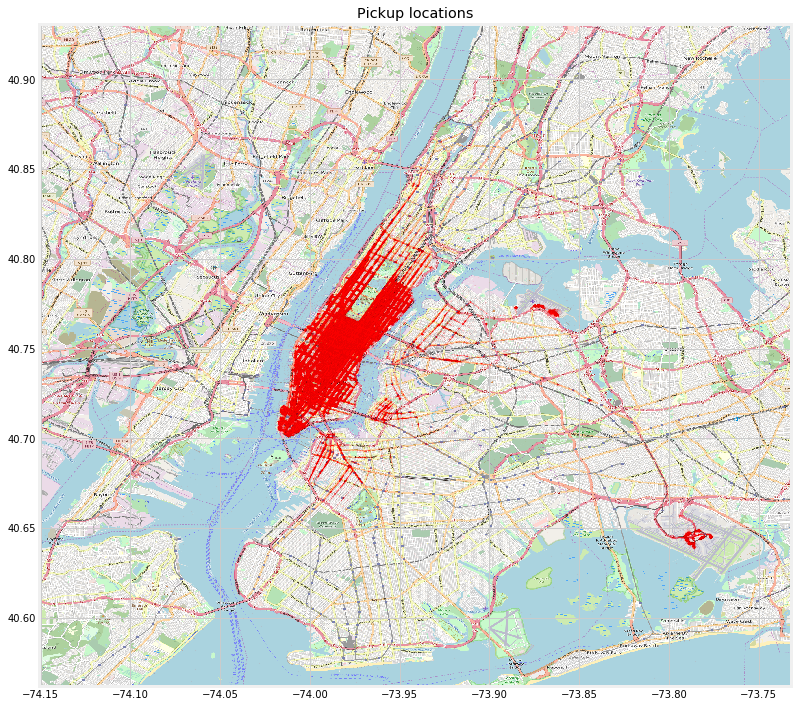

In [14]:
# plot training data on map zoomed in
plot_on_map(lat = data.pickup_latitude, long = data.pickup_longitude, s=0.5, alpha=0.05, title ='Pickup locations')

##  3.2 Dropoff Locations

Now lets create a map for the **dropoff** locations 

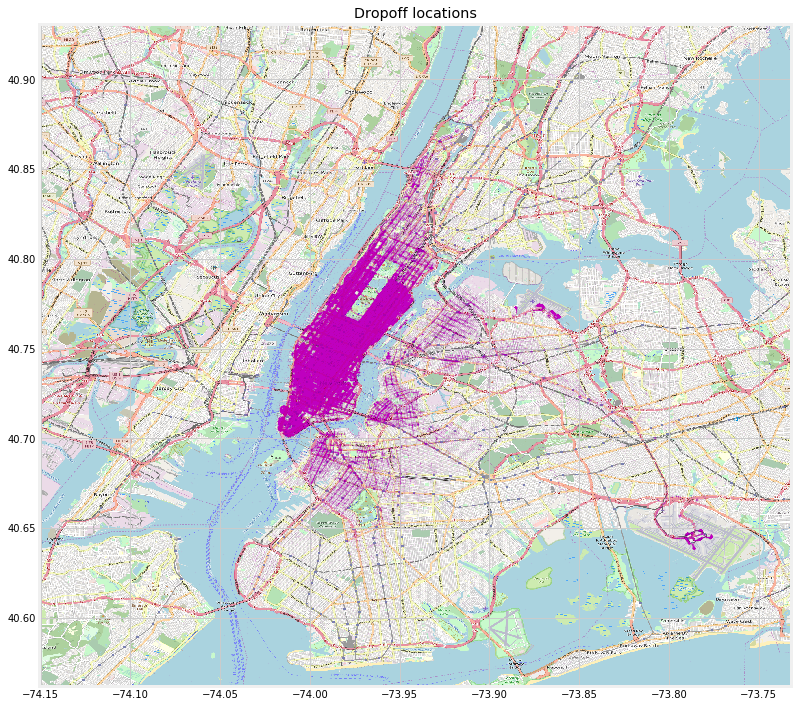

In [15]:
plot_on_map(lat = data.dropoff_latitude, long = data.dropoff_longitude, s=0.5, alpha=0.05, 
            title ='Dropoff locations', color= 'm')

This looks great. We can see most of the rides start in Manhattan and end in Manhattan but a significant amount also do end in Brooklyn. Also a lot of them start and end at the La Guardia and John F Kennedy airports. Now lets plot according to fare.

## 3.3 Fares Locations

In [16]:
# giving unique colors to every bin
colors = ['b','g','r','c','m','y','yellowgreen','tan','plum','goldenrod']

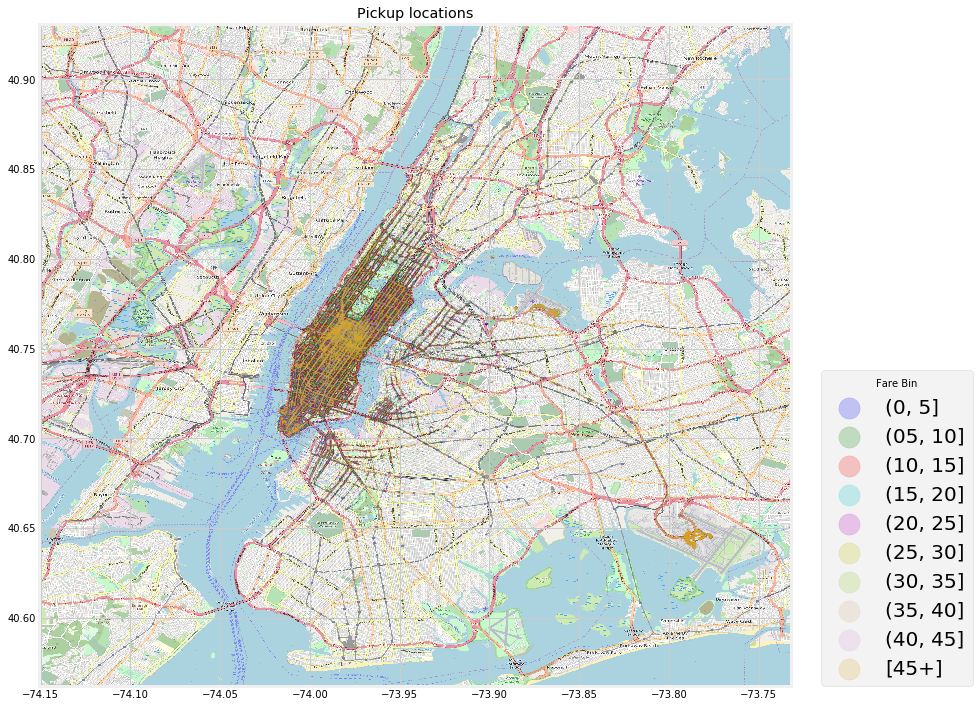

In [17]:
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)

fig, axes = plt.subplots(figsize=(12, 16))
# keeps track of index of colors for the bins
i = 0;

# Plotting the fares according to bins
for b, df in data.groupby('fare_bin'):
    axes.scatter(df.pickup_longitude, df.pickup_latitude, alpha=0.2, c=colors[i], s=0.5, label = f'{b}')
    axes.set_xlim((coordinate_tuple[0], coordinate_tuple[1]))
    axes.set_ylim((coordinate_tuple[2], coordinate_tuple[3]))
    axes.set_title('Pickup locations')
    i = i+1
    
    
legend = axes.legend(loc=(1.04,0),markerscale=30)    
legend.set_title('Fare Bin')
# finally showing the plot    
axes.imshow(nyc, zorder=0, extent=coordinate_tuple)    

Now lets plot the dropoff locations

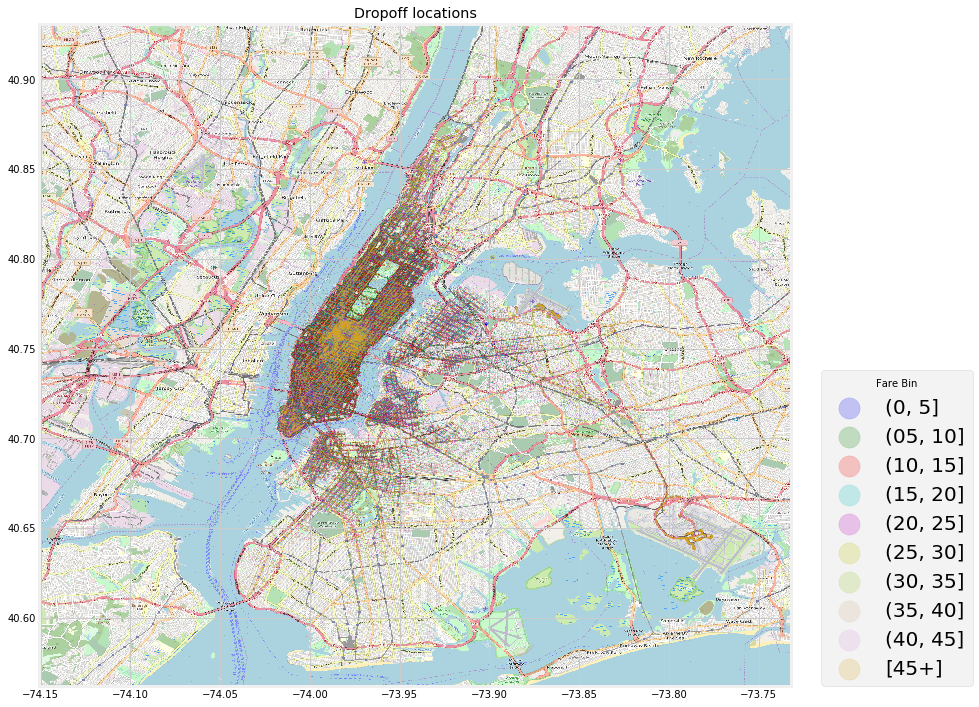

In [18]:
fig, axes = plt.subplots(figsize=(12, 16))
# keeps track of index of colors for the bins
i = 0;

# Plotting the fares according to bins
for b, df in data.groupby('fare_bin'):
    axes.scatter(df.dropoff_longitude, df.dropoff_latitude, alpha=0.2, c=colors[i], s=0.5, label = f'{b}')
    axes.set_xlim((coordinate_tuple[0], coordinate_tuple[1]))
    axes.set_ylim((coordinate_tuple[2], coordinate_tuple[3]))
    axes.set_title('Dropoff locations')
    i = i+1

# finally showing the plot     
legend = axes.legend(loc=(1.04,0) , markerscale=30)    
legend.set_title('Fare Bin')

axes.imshow(nyc, zorder=0, extent=coordinate_tuple)  

As you can see there is slight difference in the fares for the week and the highest fare is on Sunday. We will take a look at the correlation of this later. 

# Adding features 

## 4.1 Distances

### Haversine distance

Now lets add a distance column in the dataframe. Here the distance we are trying to add is the **Haversine distance** which is the Actual distance between two coordinate points. The formula for Haversine distance is:

$${\displaystyle =2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\cos(\varphi _{2})\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$$

In [19]:
# approximate radius of earth in km
R = 6373.0

# takes in coordiantes and returns distance in kilometers
def haversine_distance(lat1,long1,lat2,long2):
    lat1 = np.radians(lat1)
    long1 = np.radians(long1)
    lat2 = np.radians(lat2)
    long2 = np.radians(long2)

    dlon = long2 - long1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    distance = R * c
    return distance

data['haversine_distance'] =  haversine_distance(data.pickup_latitude,data.pickup_longitude,
                                    data.dropoff_latitude,data.dropoff_longitude)

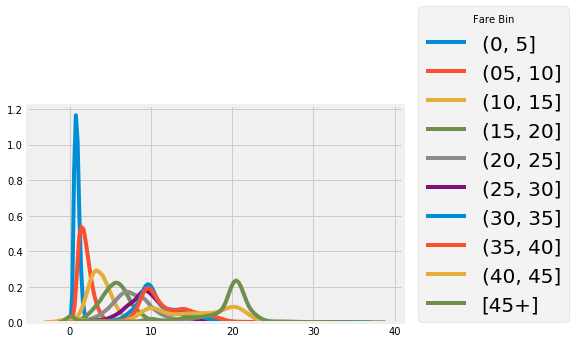

In [20]:
for b, df in data.groupby('fare_bin'):
    ax = sns.kdeplot(df.haversine_distance,  label = f'{b}')
    legend = ax.legend(loc=(1.04,0),markerscale=5) 
    legend.set_title('Fare Bin')

Before analysing this distance lets see if it agrees with common sense like the fare increases with increase in distance. For every distance this is very important otherwise either our data is bad or society does not make sense once again. 

Text(0.5, 1.0, 'Average Fare by Haversine Distance')

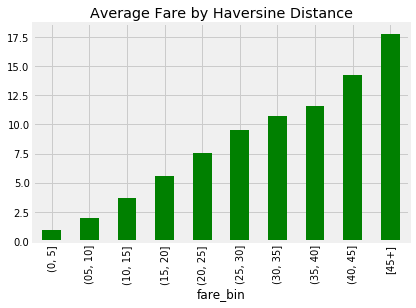

In [21]:
data.groupby('fare_bin')['haversine_distance'].mean().plot.bar(color = 'g')
plt.title('Average Fare by Haversine Distance')

it looks like this shows as you increase distance the fare increases so the data is good. 

This is the Actual distance between coordinates but what if the city was considered a 2D space and then the coordinates taken. So therefore lets add some more distance related columns in our dataframe. 

### Taxicab Distance

After searching through wikipedia I saw a something called **[Taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry)** which basically tells us a distance in city blocks. The taxicab metric is also known as rectilinear distance, L1 distance, L1 distance , snake distance, city block distance, Manhattan distance or Manhattan length, with corresponding variations in the name of the geometry. The latter names allude to the grid layout of most streets on the island of Manhattan, which causes the shortest path a car could take between two intersections in the borough to have length equal to the intersections' distance in taxicab geometry. The formula for the distance is:

$${\displaystyle D\left(X,Y\right)=|x_{1}-y_{1}| + |x_{2}-y_{2}| }$$


In [22]:
def manhattan_distance(lat1,long1,lat2,long2):
    return abs(lat1-lat2) + abs(long1-long2) 

data['manhattan_distance'] =  manhattan_distance(data.pickup_latitude,data.pickup_longitude,
                                    data.dropoff_latitude,data.dropoff_longitude)

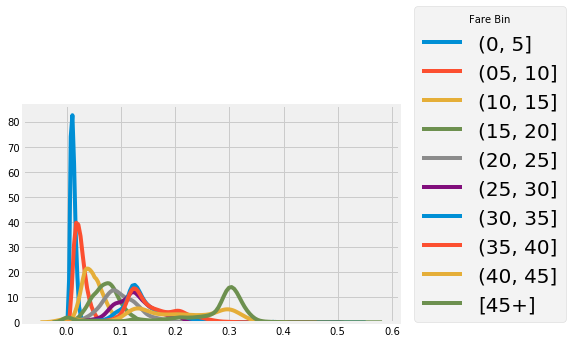

In [23]:
for b, df in data.groupby('fare_bin'):
    ax = sns.kdeplot(df.manhattan_distance,  label = f'{b}')
    legend = ax.legend(loc=(1.04,0),markerscale=5) 
    legend.set_title('Fare Bin')

Text(0.5, 1.0, 'Average Fare by Manhattan Distance')

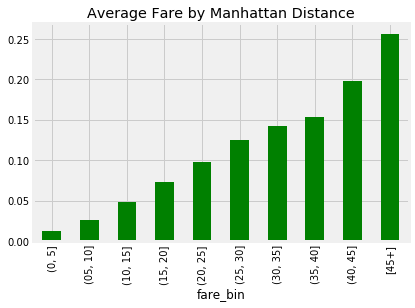

In [24]:
data.groupby('fare_bin')['manhattan_distance'].mean().plot.bar(color = 'g')
plt.title('Average Fare by Manhattan Distance')

### Euclidean distance

While we are on the topic of distances, we should not disregard the Euclidean distance because it might be better to use and might be more correlated to `fare_amount`. The formula for the Euclidean distance is:

$${\displaystyle D\left(X,Y\right)= \bigg(|x_{1}-y_{1}|^2 + |x_{2}-y_{2}|^2\bigg)^{1/2}}$$

In [25]:
def euclidean_distance(lat1,long1,lat2,long2):
    return (abs(lat1-lat2) ** 2 + abs(long1-long2) ** 2) **(1/2)

data['euclidean_distance'] =  euclidean_distance(data.pickup_latitude,data.pickup_longitude,
                                    data.dropoff_latitude,data.dropoff_longitude)

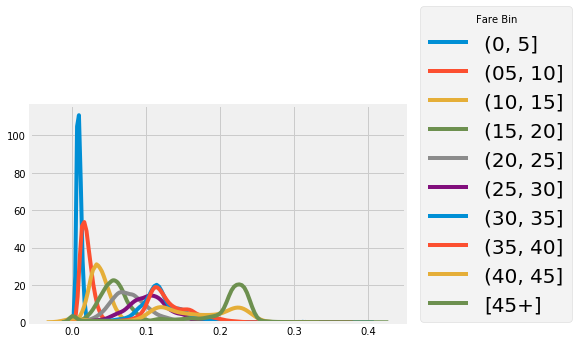

In [26]:
for b, df in data.groupby('fare_bin'):
    ax = sns.kdeplot(df.euclidean_distance,  label = f'{b}')
    legend = ax.legend(loc=(1.04,0),markerscale=5) 
    legend.set_title('Fare Bin')

Text(0.5, 1.0, 'Average Fare by Euclidean Distance')

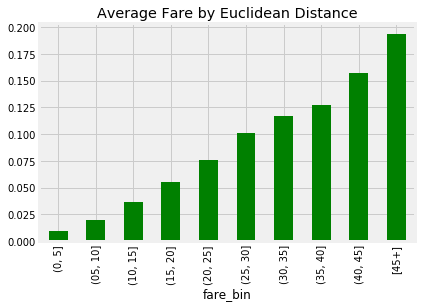

In [27]:
data.groupby('fare_bin')['euclidean_distance'].mean().plot.bar(color = 'g')
plt.title('Average Fare by Euclidean Distance')

### Vertical or horizontal distance

It might be the case where the it might be dependent on the vertical distance (differences between longitudes) or horizontal distance( differences between latitudes) or the sum of both. 

In [28]:
data['lat_diff'] = abs(data['dropoff_latitude'] - data['pickup_latitude'])
data['long_diff'] = abs(data['dropoff_longitude'] - data['pickup_longitude'])

## 4.2 Fare Per Kilometer 

Finally, before we apply machine learning lets just take a look at the `fare_amount` and `passenger_count`. 

Text(0.5, 1.0, 'Average Fare by Passenger Count')

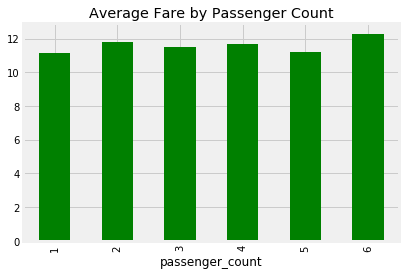

In [29]:
data.groupby('passenger_count')['fare_amount'].mean().plot.bar(color = 'g')
plt.title('Average Fare by Passenger Count')

It does not look like a lot of changes in the average fare by passenger count. This is expected because when you call a taxi it does not charge by the number of people you have. Nowdays Uber and lyft have just started the sharing of taxi but that data is not existent in my data.

Finally lets add what the fare per distance was:

In [30]:
data['fare_per_km'] = data.fare_amount / data.haversine_distance

## 4.3 Time 

Now lets add time parameters. This might be a really useful feature. 

In [31]:
# add day to the data
week = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
def add_week_day(row):
    return week[row['pickup_datetime'].weekday()]
data['pickup_day'] = data.apply(add_week_day, axis=1)

def add_weekcode(row):
    return row['pickup_datetime'].weekday()

data['day'] = data.apply(add_weekcode, axis=1)

# add year to the data
def add_year(row):
    return row['pickup_datetime'].year

data['year'] = data.apply(add_year, axis=1)

# add hour to the data
def add_hour(row):
    return row['pickup_datetime'].hour

data['hour'] = data.apply(add_hour, axis=1)

Text(0.5, 1.0, 'Average Fare by the day of travel')

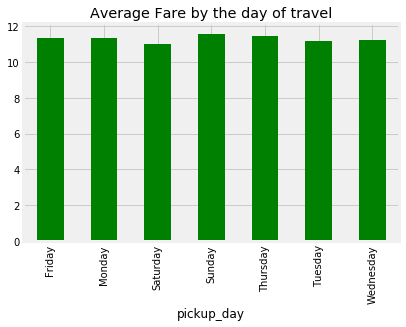

In [32]:
data.groupby('pickup_day')['fare_amount'].mean().plot.bar(color = 'g')
plt.title('Average Fare by the day of travel')

Text(0.5, 1.0, 'Average Fare by the year')

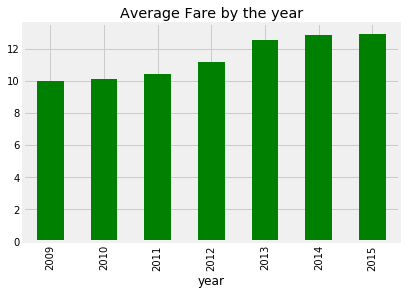

In [33]:
data.groupby('year')['fare_amount'].mean().plot.bar(color = 'g')
plt.title('Average Fare by the year')

Year 2009  is colored as  b
Year 2010  is colored as  g
Year 2011  is colored as  r
Year 2012  is colored as  c
Year 2013  is colored as  m
Year 2014  is colored as  y
Year 2015  is colored as  yellowgreen


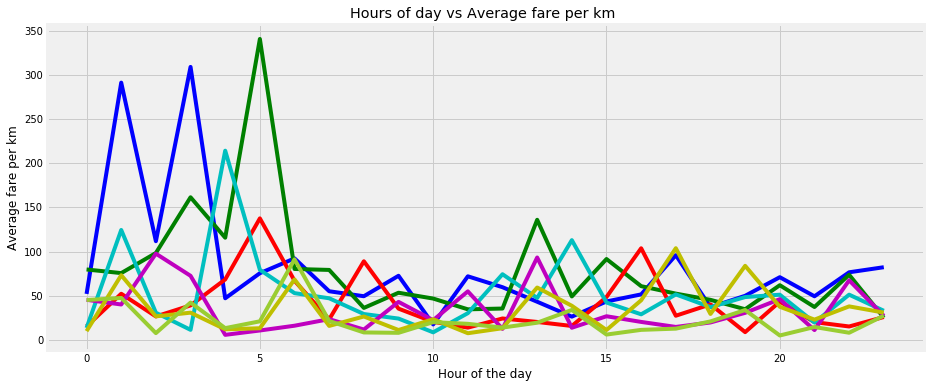

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

i=0
for b, df in data.groupby('year'):
    p = df.groupby('hour', as_index=True).aggregate({'fare_per_km': np.mean}).plot(ax=ax, legend = False, c=colors[i])
    p.set_xlabel("Hour of the day")
    p.set_ylabel("Average fare per km")
    p.set_title('Hours of day vs Average fare per km ')
    print('Year',b,' is colored as ',colors[i])
    i=i+1
plt.show()

As you can see here, 2009 and 2010 were the most expensive years for Taxi and it is considerbally more expensive to take a taxi late at night or early in the morning then it is to take in the middle of the day. After afternoon though the prises increase than the morning. Looking at this, we can say that `year` and `hour` will be a significant variable in our modal. 

# Machine Learning

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## 5.1 Splitting Data

Lets now just split the data and then train a linear regression modal with not a lot of variables.

In [36]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), stratify = data['fare_bin'], random_state = seed)

## 5.2 Finding Correlations

First lets plot out a correlation table to test what variables correlate. This will help us choose features on which we should train our modals.

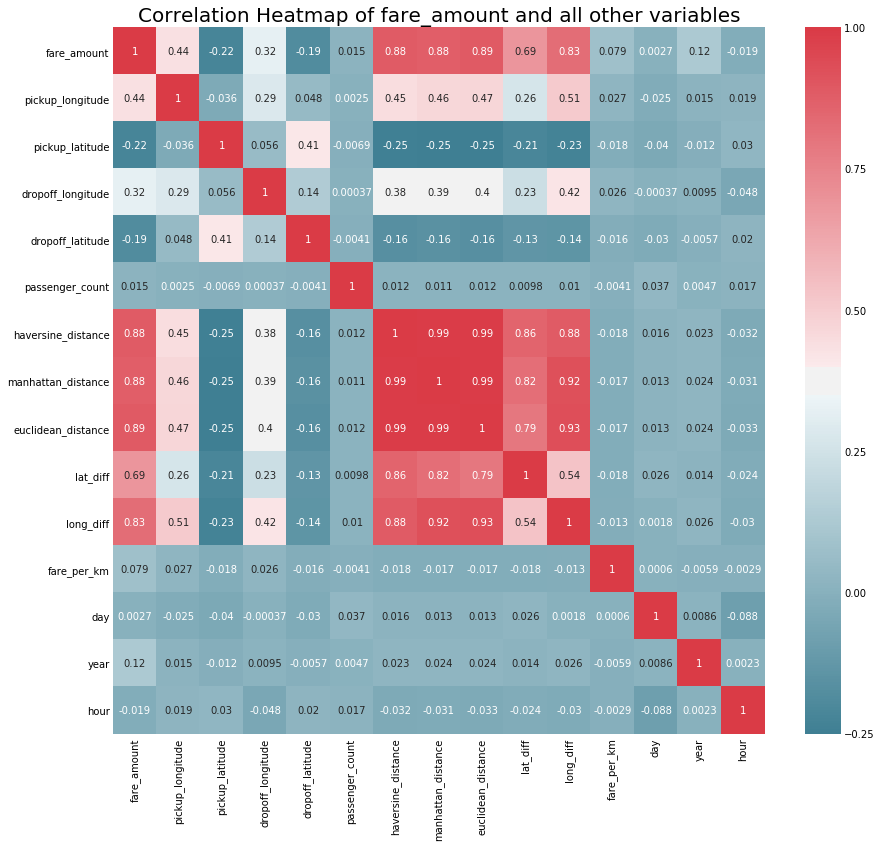

In [37]:
plt.figure(figsize=(13,13))
plt.title("Correlation Heatmap of fare_amount and all other variables", fontsize=20)
sns.heatmap(data.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)
plt.show()

This heatmap shows us that the `fare_amount` is correlated mostly to distances but also the distances are correlated to each other. Therefore when making a modal we should consider using only one of the distance and if 2 distances are used then an interaction term should be kept in mind so that the predictions are not bias.

Before doint anything lets take a look at what features we should be using.

## 5.3 Hypothesis Testing 

We are looking at the impacts of a lot of things on `fare_amount`.

**Null Hypothesis**: None of the attributes have a noticeable impact on the `fare_amount`.

To test this lets make a regression and see the F values and the P-value associated with them.

In [38]:
cols = ['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 
        'passenger_count', 'haversine_distance', 'manhattan_distance', 'euclidean_distance',   
        'lat_diff', 'long_diff', 'fare_per_km', 'day', 'year','hour']

In [39]:
from statsmodels import api as sm

X= X_train[cols]
y = y_train

#add a constant to the features
sm_X = sm.add_constant(X)

# use Ordinary Least Squares
OLS_model = sm.OLS(y,X).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 7.089e+05
Date:                Fri, 07 Dec 2018   Prob (F-statistic):               0.00
Time:                        08:33:57   Log-Likelihood:            -2.0204e+06
No. Observations:              722941   AIC:                         4.041e+06
Df Residuals:                  722928   BIC:                         4.041e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
pickup_longitude      11.3909      0.129     88.026      0.000      11.137      11.645
pickup_latitude        2.6012      0.185     14.030      0.000       2.238       2.965
dropoff_longitude     -5.0876      0.124    -41.189      0.000      -5.330      -4.846
dropoff_latitude     -14.0751      0.162    -86.916      0.000     -14.392     -13.758
passenger_count        0.0354      0.004      9.940      0.000       0.028       0.042
haversine_distance    -3.6044      0.116    -31.009      0.000      -3.832      -3.377
manhattan_distance   -74.8252      0.562   -133.038      0.000     -75.928     -73.723
euclidean_distance   714.8768     11.422     62.590      0.000     692.491     737.263
lat_diff              25.7457      1.900     13.549      0.000      22.021      29.470
long_diff           -100.5709      1.897    -53.013      0.000    -104.289     -96.853
fare_per_km            0.0004   2.03e-06    189.754      0.000       0.000       0.000
day                   -0.0445      0.002    -18.549      0.000      -0.049      -0.040
year                   0.4661      0.002    192.889      0.000       0.461       0.471
hour                   0.0112      0.001     15.507      0.000       0.010       0.013
==============================================================================
Omnibus:                   723770.748   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        201484347.010
Skew:                           4.368   Prob(JB):                         0.00
Kurtosis:                      84.317   Cond. No.                     6.22e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.87e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

After looking at this and considering our significance value of 0.05, there is sufficient evidence to **reject the Null hypothesis** and saw that there might be a relationship with the dependent variable `fare_amount`.

Some concern might be of the R-squared value of 0.927 which might mean that we might have overfit our data. We will take a look at this later when we are trying to modal non-linear regressions. 

As you can see all the cols act as good feature for the modal but we cannot use all distances at once because they are highly correlated. For our modal we cannot use any 2 variables which are highly correlated. Therfore I choose some features whose f values will come out to be the maximum.

## 5.4 F Tests

In [40]:
f_scores, p_values = f_regression(X_train[cols], y_train)
for i in range(len(cols)):
    print('Feature',cols[i])
    print('F Value',round(f_scores[i],4))
    print('P Value',p_values[i])
    print()

Feature pickup_longitude
F Value 169578.2521
P Value 0.0

Feature pickup_latitude
F Value 36359.007
P Value 0.0

Feature dropoff_longitude
F Value 84467.8839
P Value 0.0

Feature dropoff_latitude
F Value 26562.883
P Value 0.0

Feature passenger_count
F Value 180.1921
P Value 4.450569130926191e-41

Feature haversine_distance
F Value 2575886.9882
P Value 0.0

Feature manhattan_distance
F Value 2411847.3968
P Value 0.0

Feature euclidean_distance
F Value 2796496.9778
P Value 0.0

Feature lat_diff
F Value 659339.8593
P Value 0.0

Feature long_diff
F Value 1586523.4691
P Value 0.0

Feature fare_per_km
F Value 4683.2604
P Value 0.0

Feature day
F Value 7.7309
P Value 0.005428537062627677

Feature year
F Value 10643.4258
P Value 0.0

Feature hour
F Value 267.0003
P Value 5.24175101532613e-60



It looks like all of the columns we were looking at have p values which are close to 0. Moreover looking at the F values I think we should use 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 
'dropoff_latitude', 'passenger_count','haversine_distance','long_diff','lat_diff','day','year' and 'hour' as features in our modal. 

## 5.5 Making Predictions

### Linear Modal

Lets create a simple linear regression modal with features as `passenger_count` and `haversine_distance` and then lets find its square mean error. 

In [41]:
linear1 = LinearRegression().fit(X_train[['passenger_count','haversine_distance']], y_train)

In [42]:
print( linear1.intercept_,' is the intercept of the modal')
print( linear1.coef_[0],' is the coefficient for passenger count')
print( linear1.coef_[1],' is the coefficient for haversine distance')

3.454375954497558  is the intercept of the modal
0.034443223519930795  is the coefficient for passenger count
2.3278743661513563  is the coefficient for haversine distance


This means for every passenger the `fare_amount` increases by \\$0.33 and for very `haversine_distance` travelled it increases by \\$2.32. 

Now lets find the mean scored error to score our modal. 

In [43]:
mean_squared_error( y_valid , linear1.predict(X_valid[['passenger_count','haversine_distance']]) )

19.117414719081623

Lets try to do better by adding more features. 

In [44]:
features = ['pickup_longitude', 'pickup_latitude','dropoff_longitude', 
'dropoff_latitude', 'passenger_count','haversine_distance','long_diff','lat_diff','day','year','hour']

In [45]:
linear2 = LinearRegression().fit(X_train[features], y_train)

In [126]:
print( linear2.intercept_,' is the intercept of the modal')
print( linear2.coef_[4],' is the coefficient for passenger count')
print( linear2.coef_[5],' is the coefficient for haversine distance')

-794.846848540314  is the intercept of the modal
0.03210273478955826  is the coefficient for passenger count
3.646548843004844  is the coefficient for haversine distance


In [46]:
scores = cross_val_score(linear2, X_train[features], y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f) for a Linear Regression  from 10 fold cross-validation" % (scores.mean(), scores.std() * 2))

Accuracy: 0.81 (+/- 0.01) for a Linear Regression  from 10 fold cross-validation


In [47]:
linear2_prediction = linear2.predict(X_valid[features])

In [48]:
mean_squared_error( y_valid ,  linear2_prediction)

16.412474585460068

In [49]:
linear2.score(X_train[features], y_train)

0.8117285370429997

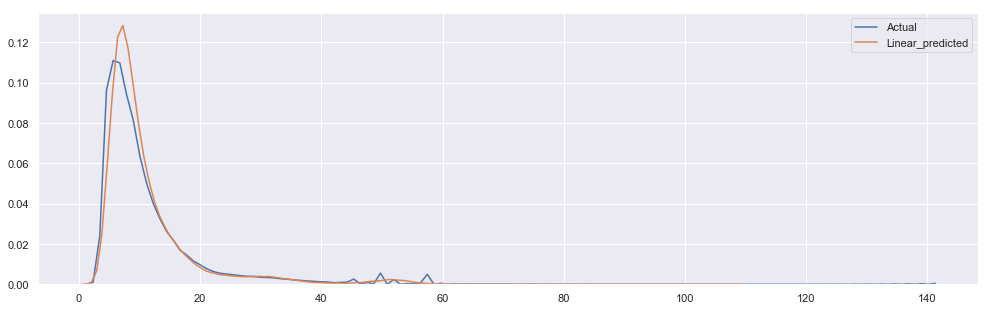

In [50]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(y_valid,  label = 'Actual')
sns.kdeplot(linear2_prediction,  label = 'Linear_predicted')
plt.show()

The lower our mean sqaured error will be the better we were able to fit our modal. It seems that we can do better if we take a look at other models. Lets take a look at how good other modals are and then in the end analyse the one which gave the best score. 

### Random Forest

In [110]:
# Fitting Model with RandomForest Algorithm and then printing the score of the predictions
rfr = RandomForestRegressor().fit(X_train[features], y_train)

In [115]:
scores = cross_val_score(rfr, X_train[features], y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f) for a Random Forest from 10 fold cross-validation" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.01) for a Random Forest from 10 fold cross-validation


In [111]:
rfr_prediction = rfr.predict(X_valid[features]) 

In [112]:
mean_squared_error( y_valid , rfr_prediction )

12.208232721247732

In [113]:
rfr.score(X_train[features], y_train)

0.9745504222243415

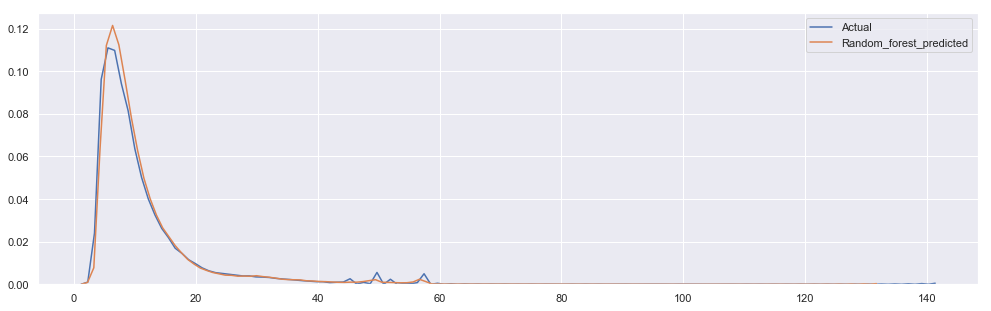

In [114]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(y_valid,  label = 'Actual')
sns.kdeplot(rfr_prediction,  label = 'Random_forest_predicted')
plt.show()

### K-NN modal

In [57]:
knn = KNeighborsRegressor(n_neighbors=20).fit(X_train[features], y_train)

In [79]:
scores = cross_val_score(knn, X_train[features], y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f) for KNN from 10 fold cross-validation" % (scores.mean(), scores.std() * 2))

Accuracy: 0.81 (+/- 0.01) for KNN from 10 fold cross-validation


In [62]:
knn_prediction = knn.predict(X_valid[features]) 

In [63]:
mean_squared_error( y_valid , knn_prediction )

16.239174284268255

In [64]:
knn.score(X_train[features], y_train)

0.8310144835024129

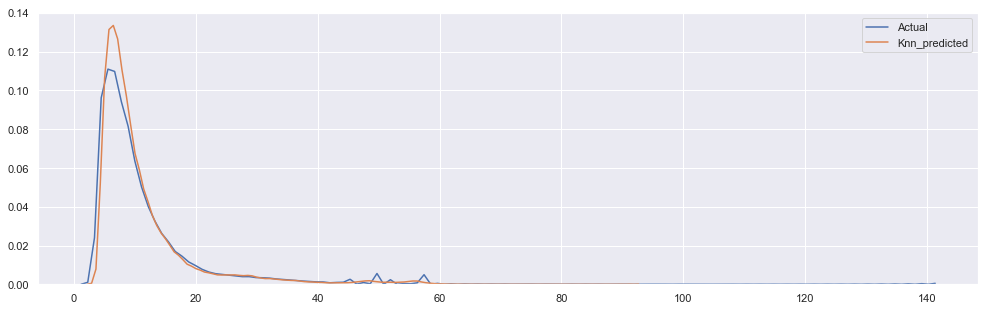

In [65]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(y_valid,  label = 'Actual')
sns.kdeplot(knn_prediction,  label = 'Knn_predicted')
plt.show()

### Decision Trees

In [66]:
decisionTree = DecisionTreeRegressor().fit(X_train[features], y_train)

In [77]:
scores = cross_val_score(decisionTree, X_train[features], y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f) for Decision Tree from 10 fold cross-validation" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.02) for Decision Tree from 10 fold cross-validation


In [67]:
dt_prediction = decisionTree.predict(X_valid[features]) 

In [68]:
mean_squared_error( y_valid , dt_prediction )

22.39747765591478

In [69]:
decisionTree.score(X_train[features], y_train)

1.0

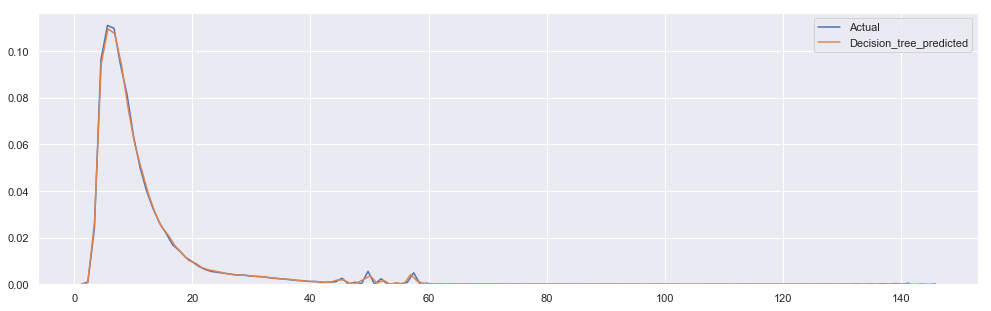

In [70]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(y_valid,  label = 'Actual')
sns.kdeplot(dt_prediction,  label = 'Decision_tree_predicted')
plt.show()

### Linear SVR

In [71]:
SVR = LinearSVR().fit(X_train[features], y_train)

In [78]:
scores = cross_val_score(SVR, X_train[features], y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f) for Linear SVR from 10 fold cross-validation" % (scores.mean(), scores.std() * 2))

Accuracy: 0.63 (+/- 0.60) for Linear SVR from 10 fold cross-validation


In [72]:
SVR_prediction = SVR.predict(X_valid[features]) 

In [73]:
mean_squared_error( y_valid , SVR_prediction )

20.11530479895405

In [74]:
SVR.score(X_train[features], y_train)

0.7696818338223528

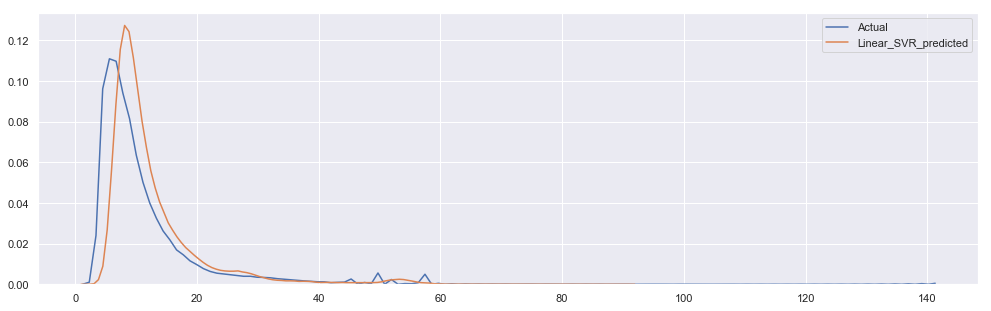

In [75]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(y_valid,  label = 'Actual')
sns.kdeplot(SVR_prediction,  label = 'Linear_SVR_predicted')
plt.show()

# Conclusion

It looks like the we should use Random Forest to predict the `fare_amount` from the features we have. Lets take a look at what the best hyper parameters are of the model. 

## Tuning the model

In [107]:
param_grid3 = {"n_estimators": [20, 40, 50],
              "max_depth": [10, 20],
              "min_samples_split": [5, 10],
              "min_samples_leaf": [3, 5],
              "max_leaf_nodes": [14, 15]}

grid_search = GridSearchCV(rfr, param_grid=param_grid3,n_jobs =3, cv = 10)
grid_search.fit(X_train[features], y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'n_estimators': [20, 40, 50], 'max_depth': [10, 20], 'min_samples_split': [5, 10], 'min_samples_leaf': [3, 5], 'max_leaf_nodes': [14, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=15,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [124]:
scores = cross_val_score(grid_search.best_estimator_, X_train[features], y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f) for Best Random Forest Model from 10 fold cross-validation" % (scores.mean(), scores.std() * 2))

Accuracy: 0.81 (+/- 0.01) for Best Random Forest Model from 10 fold cross-validation


Now lets see what features does give the immportance to the most. 

## Feature Importance

Lets see what are the most important feature used in our modal and also rank the others. 

Feature ranking:
1. feature haversine_distance (0.949642)
2. feature long_diff (0.022159)
3. feature year (0.013055)
4. feature dropoff_longitude (0.010843)
5. feature lat_diff (0.003666)
6. feature pickup_longitude (0.000636)
7. feature hour (0.000000)
8. feature day (0.000000)
9. feature passenger_count (0.000000)
10. feature dropoff_latitude (0.000000)
11. feature pickup_latitude (0.000000)


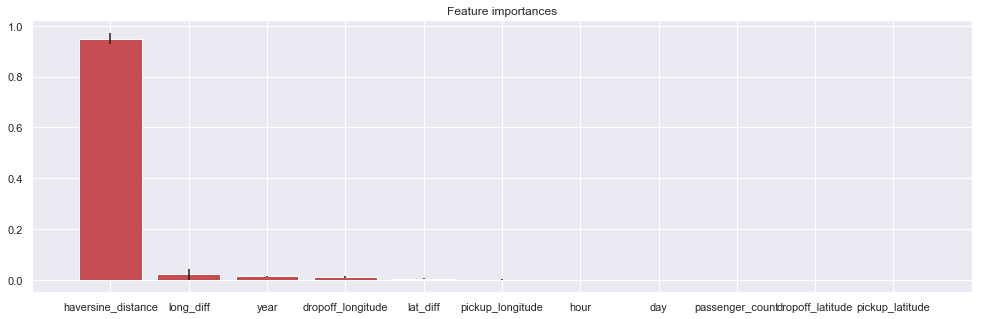

In [123]:
rfr= grid_search.best_estimator_
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

x_labels = []

# Print the feature ranking
print("Feature ranking:")

for f in range(11):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    x_labels.append(features[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(11), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(11), x_labels)
plt.xlim([-1,11])
plt.show()

As you can see above our `fare_amount` is mostly dependent on `haversine_distance` and is somewhat dependent on `long_diff`, `year` and `dropoff_longitude`. Therefore predicting the fares can be directly tied to needing atleast these features for a good prediction. Of course we can later add in the new data and the importance of features can change. Right now we are able to predict a really good percentage of the data with a good accurancy. I wanted to end by running this code which would plot the learning curve and then show that we could benefit from fitting more data. 

```
from sklearn.model_selection import learning_curve

train_sizes = np.arange(1, data.size,100000)
train_sizes[len(train_sizes)-1] = data.size
train_sizes, train_scores, valid_scores = learning_curve(rfr, X_train[features], y_train, train_sizes=train_sizes, cv=10)           
plt.plot(x=train_sizes, y=train_scores, c= 'b')
plt.plot(x=train_sizes,y=valid_scores, c= 'r')
plt.show()
```

---

Thank you for reading! Any comments/criticisms of methodology, analysis, display, clarity of writing, or lack of actual football knowledge are warmly welcomed!